# Loading Dataset

You can download the dataset from {https://darwin.v7labs.com/v7-labs/covid-19-chest-x-ray-dataset?sort=priority\%3Adesc}.
The data entitled as '`darwin dataset pull v7-labs/covid-19-chest-x-ray-dataset:all-images`' will be used in this assignment. All dataset consist of 6504 images from 702 classes. We will extract the images of 4 classes (Bacterial Pneumonia, Viral Pneumonia, No Pneumonia (healthy), Covid-19) and save them as .npy file with the following code:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/deep learning/Deep Learning assignment

#hoi

In [ ]:
import json
import numpy as np
import glob
import pandas as pd

# importing modules
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf

# all-images file should be uploaded to the same file
imageNames = glob.glob(r"/content/gdrive/MyDrive/Deep Learning assignment/all-images/*.json")

dataset = []
labels = []

for i, imName in enumerate(imageNames):

    # Opening JSON file
    f = open(imName)
    data = json.load(f)
    for j in range(len(data['annotations'])):

        if 'COVID-19' in (data['annotations'][j]['name']):
          #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            print(label)
            break

        if 'Viral Pneumonia' in (data['annotations'][j]['name']) \
            or 'Bacterial Pneumonia' in (data['annotations'][j]['name']) \
            or 'No Pneumonia (healthy)' in (data['annotations'][j]['name']):
            #load images from url    
            urllib.request.urlretrieve(data['image']['url'],"img.png")    
            img = Image.open("img.png")
            #convert images to grayscale
            imgGray = img.convert('L')
            #resize the image (156x156)
            im = imgGray.resize((156,156), Image.LANCZOS)           
            label = data['annotations'][j]['name']
            dataset.append(np.array(im))
            labels.append(label)
            break

#Convert data shape of (n_of_samples, width, height, 1)
dataset = np.dstack(dataset)    
dataset = np.rollaxis(dataset,-1)
labels = np.array(labels)

#convert images gray scale to rgb
data = np.array(layers.Lambda(tf.image.grayscale_to_rgb)(tf.expand_dims(dataset, -1)))

# save data and labels into a folder
np.save(r"/content/drive/MyDrive/Deep Learning assignment/data", data)
np.save(r"/content/drive/MyDrive/Deep Learning assignment/labels", labels)

Once you save your data, you can load it from your directory.

In [2]:
import numpy as np
import json
import numpy as np
import glob
import pandas as pd

# importing modules
import urllib.request
from PIL import Image
from keras import layers, models
import tensorflow as tf
tf.keras.utils.set_random_seed(43)

data = np.load(r'/Users/jurrienboogert/Documents/Data_Science_Society/deep learning/assignment/data/data.npy')
labels = np.load(r'/Users/jurrienboogert/Documents/Data_Science_Society/deep learning/assignment/labels/labels.npy')

In [5]:
# show imbalance
print(dict(enumerate(pd.DataFrame(labels).value_counts().sort_index())))
print(len(labels))

{0: 2816, 1: 127, 2: 1606, 3: 1843}
6392


# Preprocessing Steps



## Splitting Data

In [91]:
from sklearn.model_selection import train_test_split

# Split the data and labels into train and test sets (80% training, 20% testing)
trainX, testX, trainy, y_test = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)

# Split the training data and labels into train and validation sets (60% training, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(trainX, trainy, test_size=0.25, stratify=trainy, random_state=42)



In [ ]:
# manual data agumentation on COVID class
"""
covid_data = X_train[y_train == 'COVID-19']
covid_labels = y_train[y_train == 'COVID-19']

for i in range(22):

    X_batch, Y_batch = datagen.flow(covid_data, covid_labels, batch_size=127, shuffle=True, seed=43).next()

    X_train = np.concatenate((X_train, X_batch))
    y_train = np.concatenate((y_train, Y_batch))
    print(X_train.shape, y_train.shape)
"""

## Normalize Data

In [92]:
# convert from integers to floats
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = testX.astype('float32')


# normalize to range 0-1
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# !!!!! turn off for transfer learning !!!!
X_train = X_train[:,:,:,0:1]
X_val = X_val[:,:,:,0:1]
X_test = X_test[:,:,:,0:1]

One-hot-encoding

In [93]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical



# Convert labels to integer values
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

# Convert integer labels to one-hot encoded binary vectors
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)



In [ ]:
print("xtrain",X_train.shape)
print("ytrain", y_train.shape)
print()
print("xval", X_val.shape)
print("yval", y_val.shape)
print()
print("xtest", X_test.shape)
print("ytest", y_test.shape)

### define and load metrics functions

In [94]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import classification_report

def plot_loss_acc(history, savefig_loss, savefig_acc):
    # Get the training and validation loss and accuracy values from the training history
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    # Plot the training and validation losses and accuracies
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, '-', color = "orange", label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(savefig_loss)
    plt.show()

    plt.plot(epochs, train_acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, '-', color = "orange", label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.savefig(savefig_acc)
    plt.show()

def plot_ROC_AUC(X,y, savefig):
    # Load the validation data and corresponding labels

    num_classes = 4

    # Use the trained model to predict the class probabilities for the validation set
    y_prob = model.predict(X)

    # Compute micro-average ROC curve and ROC area
    fpr_micro, tpr_micro, _ = roc_curve(y.ravel(), y_prob.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)

    # Compute macro-average ROC curve and ROC area
    fpr_macro = dict()
    tpr_macro = dict()
    roc_auc_macro = dict()
    for i in range(num_classes):
        fpr_macro[i], tpr_macro[i], _ = roc_curve(y[:, i], y_prob[:, i])
        roc_auc_macro[i] = auc(fpr_macro[i], tpr_macro[i])

    # Plot micro-average ROC curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr_micro, tpr_micro, label='micro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc_micro), color='pink', linestyle=':', linewidth=4)

    # Plot macro-average ROC curve
    fpr_macro["avg"] = np.unique(np.concatenate([fpr_macro[i] for i in range(num_classes)]))
    tpr_macro["avg"] = np.zeros_like(fpr_macro["avg"])
    for i in range(num_classes):
        tpr_macro["avg"] += np.interp(fpr_macro["avg"], fpr_macro[i], tpr_macro[i])
    tpr_macro["avg"] /= num_classes
    roc_auc_macro["avg"] = auc(fpr_macro["avg"], tpr_macro["avg"])
    plt.plot(fpr_macro["avg"], tpr_macro["avg"],
            label='macro-average ROC curve (area = {0:0.2f})'
            ''.format(roc_auc_macro["avg"]), color='navy', linestyle=':', linewidth=4)

    # Plot ROC curve for each class
    plt.plot(fpr_macro[0], tpr_macro[0], label='ROC curve of class 0 (area = {0:0.2f})'
            ''.format(roc_auc_macro[0]), color='blue', linewidth=2)
    plt.plot(fpr_macro[1], tpr_macro[1], label='ROC curve of class 1 (area = {0:0.2f})'
            ''.format(roc_auc_macro[1]), color='brown', linewidth=2)
    plt.plot(fpr_macro[2], tpr_macro[2], label='ROC curve of class 2 (area = {0:0.2f})'
            ''.format(roc_auc_macro[2]), color='yellow', linewidth=2)
    plt.plot(fpr_macro[3], tpr_macro[3], label='ROC curve of class 3 (area = {0:0.2f})'
            ''.format(roc_auc_macro[3]), color='red', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Validation)')
    plt.legend(loc="lower right")
    plt.savefig(savefig)
    plt.show()

def plot_cm(X,y,savefig):
    # Use the trained model to predict the class probabilities for the validation set
    y_prob = model.predict(X)

    # Convert the predicted probabilities to integer class labels
    y_pred = np.argmax(y_prob, axis=1)

    #convert y_val to 1d array
    y_val1d = np.argmax(y, axis=1)

    #shape check
    #print(y_test.shape)
    #print(y_pred.shape)

    # Evaluate the model on the validation set
    accuracy = accuracy_score(y_val1d, y_pred)
    precision, recall, f1_score, _ = precision_recall_fscore_support(y_val1d, y_pred, average='macro')
    cm = confusion_matrix(y_val1d, y_pred)

    print("Validation set accuracy:", accuracy)
    print("Validation set precision:", precision)
    print("Validation set recall / sensitivity:", recall)
    print("Validation set specificity:", "?")
    print("Validation set F1 score:", f1_score)

    class_names = ['Bacterial Pneumonia (Class 0)', 'Covid-19 (Class 1)', 'No Pneunomia (healthy) (Class 2)', 'Viral Pneumonia (Class 3)']

    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=[0,1,2,3], yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(savefig, bbox_inches="tight")
    plt.show()

def class_report(X,y):
    print('\nClassification Report\n')

    class_names = ['Bacterial Pneumonia (Class 0)', 'Covid-19 (Class 1)', 'No Pneunomia (healthy) (Class 2)', 'Viral Pneumonia (Class 3)']

    # Use the trained model to predict the class probabilities for the validation set
    y_prob = model.predict(X)

    # Convert the predicted probabilities to integer class labels
    y_pred = np.argmax(y_prob, axis=1)

    #convert y_val to 1d array
    y_val1d = np.argmax(y, axis=1)

    print(classification_report(y_val1d, y_pred, target_names=class_names))

# Create Baseline Model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras

# Define the model architecture
model = Sequential()
#conv layer with 64 filters and size 3x3 with relu activation + maxpool 2x2 size
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape = X_train.shape[1:]))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding = 'same'))
model.add(MaxPooling2D((2,2), padding = 'valid'))

#conv layer with 32 filters and size 3x3 with relu activation +maxpool 2x2 size
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding = 'same'))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding = 'same'))
model.add(MaxPooling2D((2,2), padding = 'valid'))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

#you can change it to sigmoid
model.add(Dense(4, activation="softmax"))

# Compile the model
#we can change the loss function
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()


Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 156, 156, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 78, 78, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 78, 78, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 39, 39, 3

2023-03-05 10:09:29.363948: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-03-05 10:09:29.363974: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [7]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10


2023-03-05 10:09:35.481109: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-03-05 10:09:35.793376: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 0.8751 - accuracy: 0.6200

2023-03-05 10:09:58.240055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 25s 205ms/step - loss: 0.8751 - accuracy: 0.6200 - val_loss: 0.6687 - val_accuracy: 0.7263
Epoch 2/10
120/120 [==============================] - 24s 199ms/step - loss: 0.5960 - accuracy: 0.7535 - val_loss: 0.5677 - val_accuracy: 0.7592
Epoch 3/10
120/120 [==============================] - 24s 199ms/step - loss: 0.5281 - accuracy: 0.7906 - val_loss: 0.5649 - val_accuracy: 0.7623
Epoch 4/10
120/120 [==============================] - 24s 200ms/step - loss: 0.4733 - accuracy: 0.8015 - val_loss: 0.5560 - val_accuracy: 0.7701
Epoch 5/10
120/120 [==============================] - 24s 199ms/step - loss: 0.4411 - accuracy: 0.8164 - val_loss: 0.6358 - val_accuracy: 0.7428
Epoch 6/10
120/120 [==============================] - 24s 198ms/step - loss: 0.3763 - accuracy: 0.8482 - val_loss: 0.7433 - val_accuracy: 0.7498
Epoch 7/10
120/120 [==============================] - 24s 198ms/step - loss: 0.3197 - accuracy: 0.8698 - val_loss: 0.6314 - val_accuracy: 0.7

# Analyze the performance of the baseline model

### validation

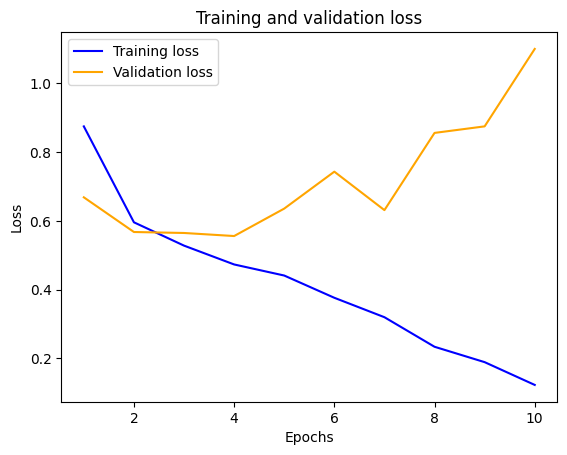

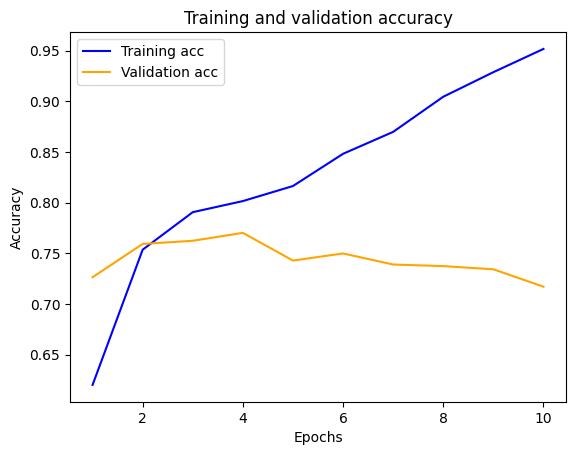

In [8]:
plot_loss_acc(history, 'basemodel_loss.png', 'basemodel_accuracy.png')

 1/40 [..............................] - ETA: 7s

2023-03-05 10:13:41.426121: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 3s 66ms/step


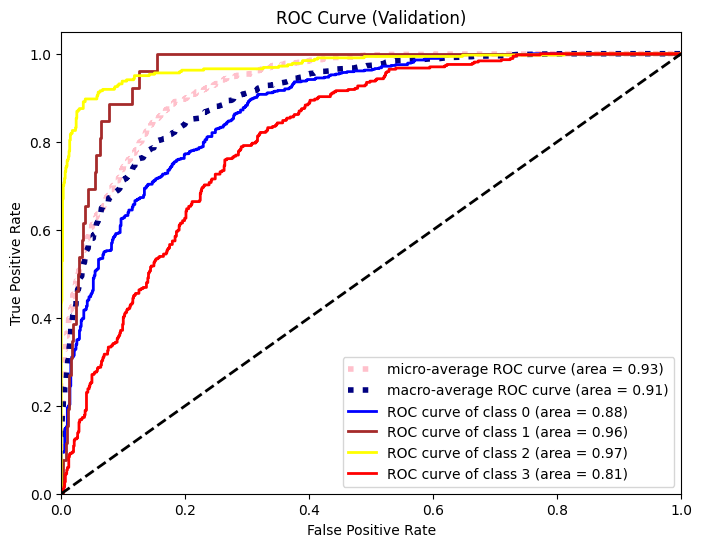

In [9]:
plot_ROC_AUC(X_val, y_val, 'basemodel_ROC_validation.png')


40/40 [==============================] - 2s 62ms/step
Validation set accuracy: 0.7169663799843627
Validation set precision: 0.6052062211515449
Validation set recall / sensitivity: 0.6103345066000048
Validation set specificity: ?
Validation set F1 score: 0.6057732025693443


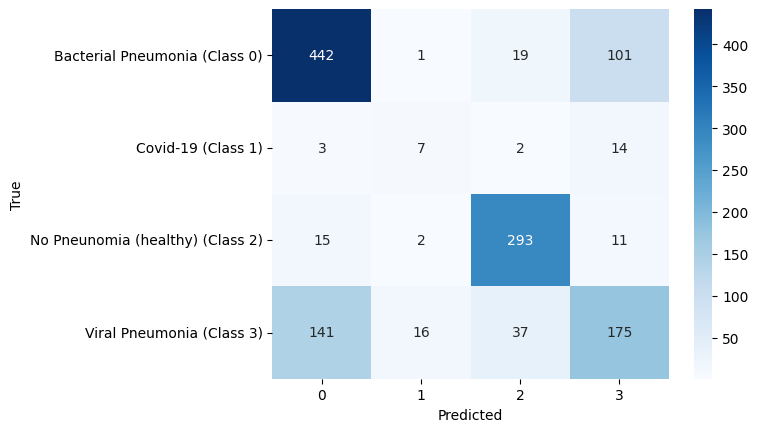

In [10]:
plot_cm(X_val, y_val, 'basemodel_validationset_confusion_matrix.png')

In [11]:
class_report(X_val,y_val)


Classification Report

40/40 [==============================] - 2s 63ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.74      0.79      0.76       563
              Covid-19 (Class 1)       0.27      0.27      0.27        26
No Pneunomia (healthy) (Class 2)       0.83      0.91      0.87       321
       Viral Pneumonia (Class 3)       0.58      0.47      0.52       369

                        accuracy                           0.72      1279
                       macro avg       0.61      0.61      0.61      1279
                    weighted avg       0.71      0.72      0.71      1279



### test

40/40 [==============================] - 3s 65ms/step


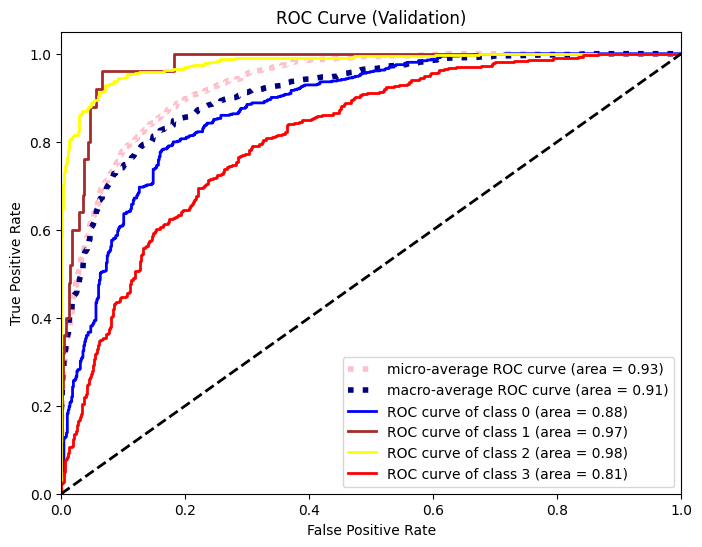

In [12]:
plot_ROC_AUC(X_test,y_test, 'basemodel_ROC_test.png')


40/40 [==============================] - 2s 63ms/step
Validation set accuracy: 0.7412040656763096
Validation set precision: 0.6655301262575081
Validation set recall / sensitivity: 0.6670525976436936
Validation set specificity: ?
Validation set F1 score: 0.6645681738454627


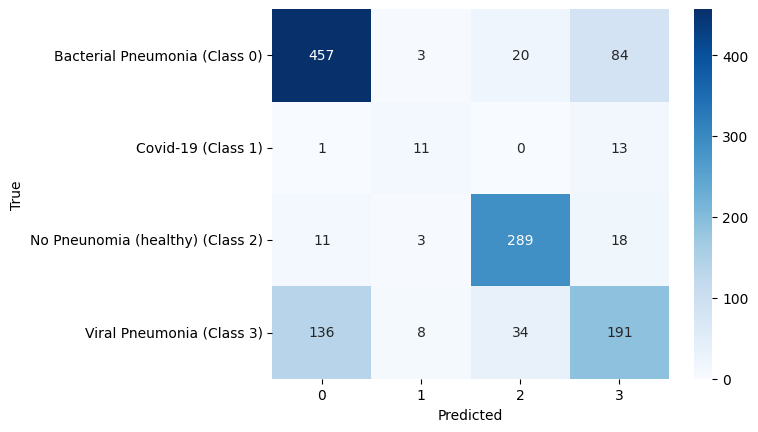

In [13]:
plot_cm(X_test,y_test,'basemodel_testset_confusion_matrix.png')


In [14]:
class_report(X_test,y_test)



Classification Report

40/40 [==============================] - 3s 65ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.76      0.81      0.78       564
              Covid-19 (Class 1)       0.44      0.44      0.44        25
No Pneunomia (healthy) (Class 2)       0.84      0.90      0.87       321
       Viral Pneumonia (Class 3)       0.62      0.52      0.57       369

                        accuracy                           0.74      1279
                       macro avg       0.67      0.67      0.66      1279
                    weighted avg       0.73      0.74      0.74      1279



# Adapting/fine-tuning the network

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import keras
tf.keras.utils.set_random_seed(43)

# Define the model architecture
model = Sequential()
#conv layer with 64 filters and size 3x3 with relu activation + maxpool 2x2 size
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape = X_train.shape[1:]))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding = 'same'))
model.add(MaxPooling2D((2,2), padding = 'valid'))

#conv layer with 32 filters and size 3x3 with relu activation +maxpool 2x2 size
model.add(layers.Conv2D(64, (3, 3), activation="relu", padding = 'same'))
model.add(layers.Conv2D(32, (3, 3), activation="relu", padding = 'same'))
model.add(MaxPooling2D((2,2), padding = 'valid'))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))

#you can change it to sigmoid
model.add(Dense(4, activation="softmax"))

# Compile the model
#we can change the loss function
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 156, 156, 64)      640       
                                                                 
 conv2d_5 (Conv2D)           (None, 156, 156, 32)      18464     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 78, 78, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 78, 78, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 78, 78, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 39, 39, 32)       0         
 2D)                                                  

### Early Stopping

In [16]:
# Early stopping after four epochs
history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/4


2023-03-05 10:14:25.283380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 0.8751 - accuracy: 0.6200

2023-03-05 10:14:47.510374: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 25s 204ms/step - loss: 0.8751 - accuracy: 0.6200 - val_loss: 0.6687 - val_accuracy: 0.7263
Epoch 2/4
120/120 [==============================] - 24s 199ms/step - loss: 0.5960 - accuracy: 0.7535 - val_loss: 0.5677 - val_accuracy: 0.7592
Epoch 3/4
120/120 [==============================] - 24s 199ms/step - loss: 0.5281 - accuracy: 0.7906 - val_loss: 0.5649 - val_accuracy: 0.7623
Epoch 4/4
120/120 [==============================] - 24s 198ms/step - loss: 0.4733 - accuracy: 0.8015 - val_loss: 0.5560 - val_accuracy: 0.7701


### validation

 2/40 [>.............................] - ETA: 2s

2023-03-05 10:16:05.422933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 3s 64ms/step


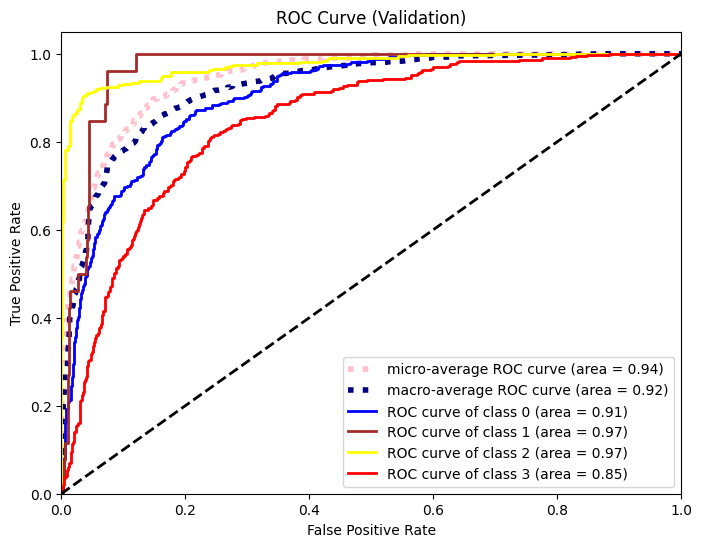

In [17]:
plot_ROC_AUC(X_val,y_val, 'basemodel_early_stopping_ROC_validation.png')

40/40 [==============================] - 2s 62ms/step
Validation set accuracy: 0.7701329163408913
Validation set precision: 0.5807110431075551
Validation set recall / sensitivity: 0.5845940553411277
Validation set specificity: ?
Validation set F1 score: 0.5815701402205178


/opt/anaconda3/envs/tflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


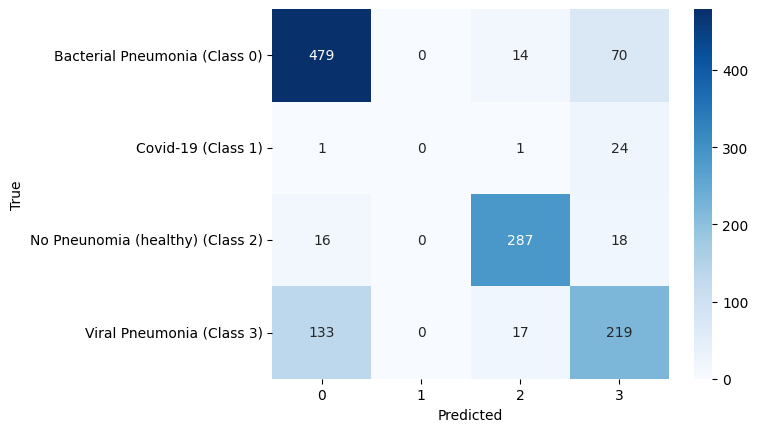

In [18]:
plot_cm(X_val,y_val,'basemodel_early_stopping_validationset_confusion_matrix.png')

In [19]:
class_report(X_val,y_val)


Classification Report

40/40 [==============================] - 2s 62ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.76      0.85      0.80       563
              Covid-19 (Class 1)       0.00      0.00      0.00        26
No Pneunomia (healthy) (Class 2)       0.90      0.89      0.90       321
       Viral Pneumonia (Class 3)       0.66      0.59      0.63       369

                        accuracy                           0.77      1279
                       macro avg       0.58      0.58      0.58      1279
                    weighted avg       0.75      0.77      0.76      1279



/opt/anaconda3/envs/tflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### test

40/40 [==============================] - 2s 61ms/step


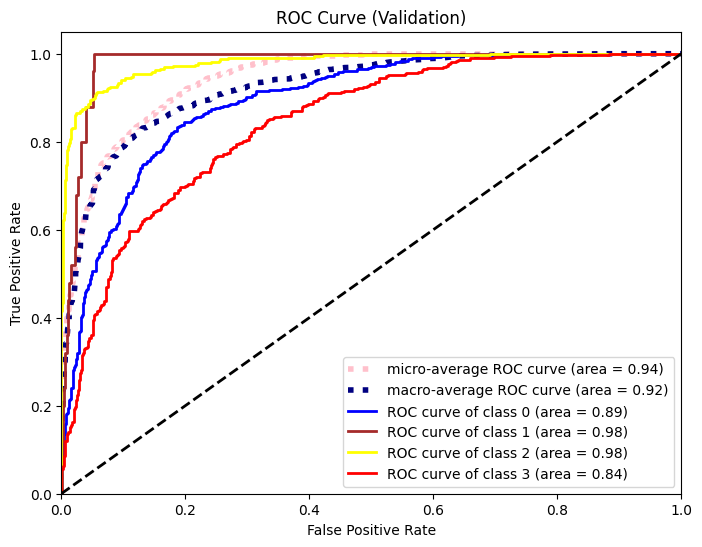

In [20]:
plot_ROC_AUC(X_test,y_test, 'basemodel_early_stopping_ROC_test.png')

40/40 [==============================] - 2s 60ms/step
Validation set accuracy: 0.7685691946833464
Validation set precision: 0.5805887268359253
Validation set recall / sensitivity: 0.5820198135367712
Validation set specificity: ?
Validation set F1 score: 0.5802843124786538


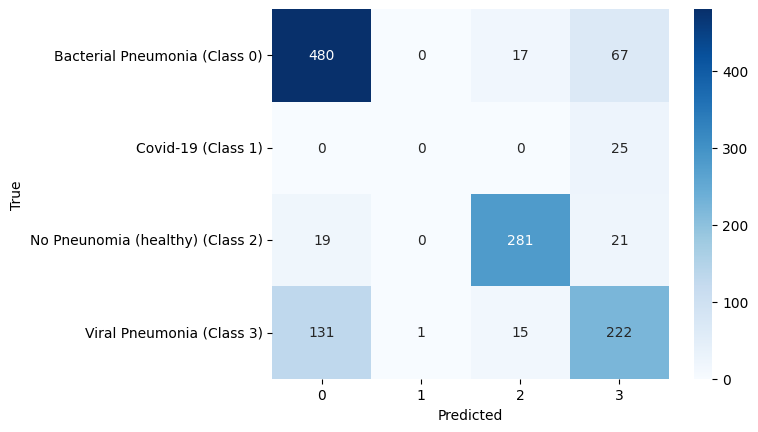

In [21]:
plot_cm(X_test,y_test,'basemodel_early_stopping_testset_confusion_matrix.png')

In [22]:
class_report(X_test,y_test)


Classification Report

40/40 [==============================] - 2s 61ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.76      0.85      0.80       564
              Covid-19 (Class 1)       0.00      0.00      0.00        25
No Pneunomia (healthy) (Class 2)       0.90      0.88      0.89       321
       Viral Pneumonia (Class 3)       0.66      0.60      0.63       369

                        accuracy                           0.77      1279
                       macro avg       0.58      0.58      0.58      1279
                    weighted avg       0.75      0.77      0.76      1279



## Reducing the model's capacity

In [46]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, AveragePooling2D
from tensorflow.keras import regularizers

from tensorflow.keras import layers, models
tf.keras.utils.set_random_seed(43)

# Define the CNN model
model = models.Sequential()

# Add the 1st convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization(axis=1))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 2nd convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 3rd convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 4th convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 5th convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 6th convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output of the last convolutional layer
model.add(layers.Flatten())

# Add the 1st dense layer
model.add(layers.Dense(32, activation='relu'))

# Add the 2nd dense layer
model.add(layers.Dense(32, activation='relu'))

# Add the output layer
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
#we can change the loss function
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0001)
model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 156, 156, 32)      320       
                                                                 
 batch_normalization_4 (Batc  (None, 156, 156, 32)     624       
 hNormalization)                                                 
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 78, 78, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 39, 39, 32)       0         
 g2D)                                                            
                                                      

In [47]:
hist = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/5


2023-03-05 10:26:41.774091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 0.9219 - accuracy: 0.5814

2023-03-05 10:26:52.072097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 12s 93ms/step - loss: 0.9219 - accuracy: 0.5814 - val_loss: 1.1524 - val_accuracy: 0.6091
Epoch 2/5
120/120 [==============================] - 11s 88ms/step - loss: 0.6397 - accuracy: 0.7384 - val_loss: 1.0285 - val_accuracy: 0.5551
Epoch 3/5
120/120 [==============================] - 11s 88ms/step - loss: 0.5698 - accuracy: 0.7770 - val_loss: 0.8044 - val_accuracy: 0.7420
Epoch 4/5
120/120 [==============================] - 11s 87ms/step - loss: 0.5282 - accuracy: 0.7872 - val_loss: 0.5796 - val_accuracy: 0.7811
Epoch 5/5
120/120 [==============================] - 11s 87ms/step - loss: 0.5053 - accuracy: 0.7960 - val_loss: 0.5413 - val_accuracy: 0.7967


### validation

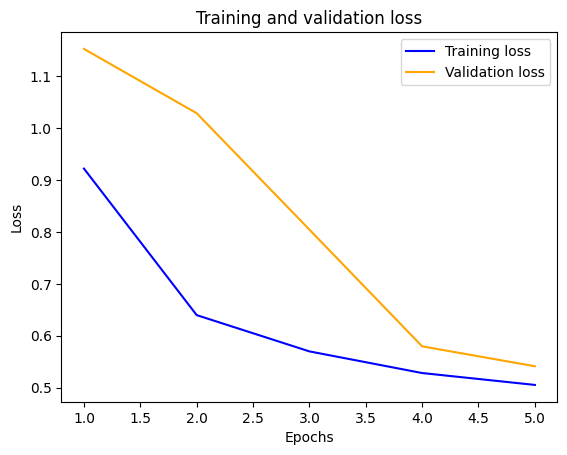

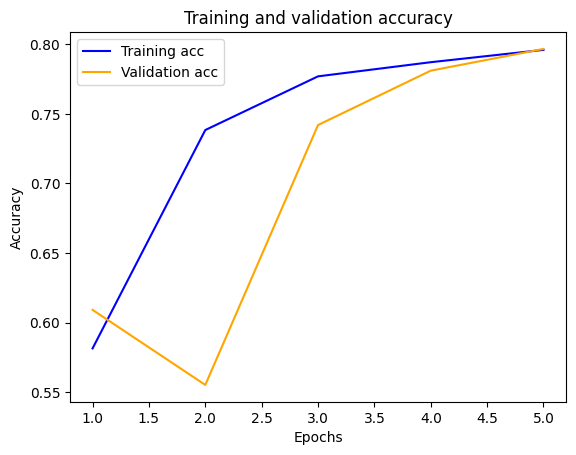

In [25]:
plot_loss_acc(hist, 'reduced_model_loss', 'reduced_model_accuracy.png')

 2/40 [>.............................] - ETA: 1s

2023-03-05 10:17:52.419612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 28ms/step


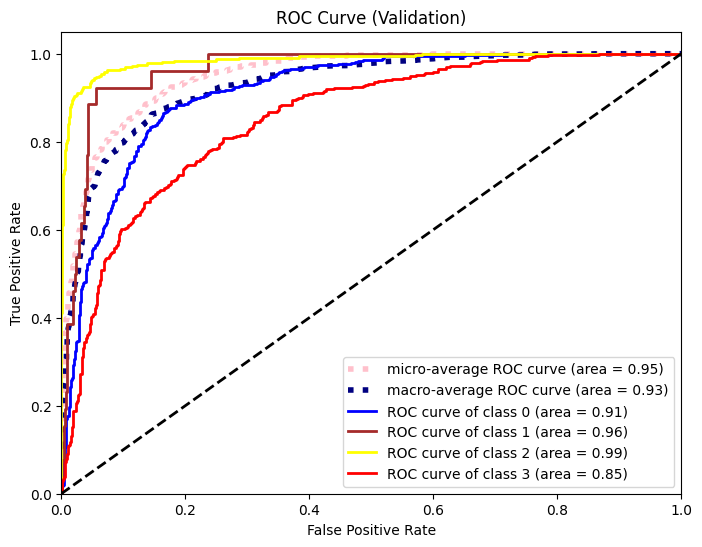

In [26]:
plot_ROC_AUC(X_val, y_val, 'reduced_model_ROC_validation.png')

40/40 [==============================] - 1s 26ms/step
Validation set accuracy: 0.7967161845191556
Validation set precision: 0.6029968432683215
Validation set recall / sensitivity: 0.6030306160949095
Validation set specificity: ?
Validation set F1 score: 0.601179035511002


/opt/anaconda3/envs/tflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


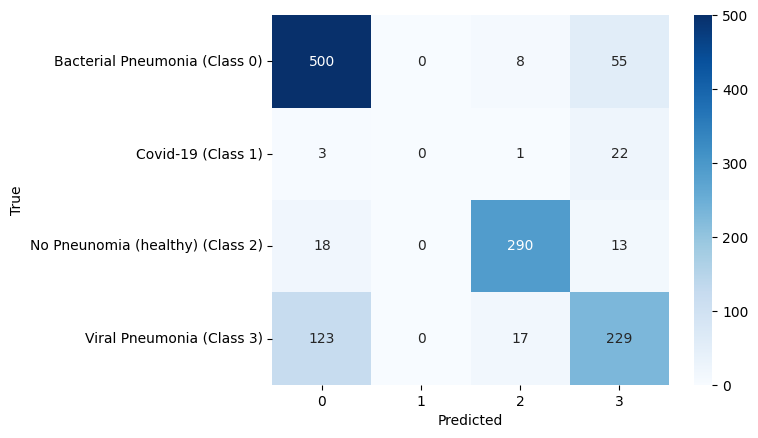

In [27]:
plot_cm(X_val,y_val, 'reduced_model_validationset_confusion_matrix.png')

In [28]:
class_report(X_val,y_val)


Classification Report

40/40 [==============================] - 1s 25ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.78      0.89      0.83       563
              Covid-19 (Class 1)       0.00      0.00      0.00        26
No Pneunomia (healthy) (Class 2)       0.92      0.90      0.91       321
       Viral Pneumonia (Class 3)       0.72      0.62      0.67       369

                        accuracy                           0.80      1279
                       macro avg       0.60      0.60      0.60      1279
                    weighted avg       0.78      0.80      0.79      1279



/opt/anaconda3/envs/tflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/tflow/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### test

40/40 [==============================] - 1s 26ms/step


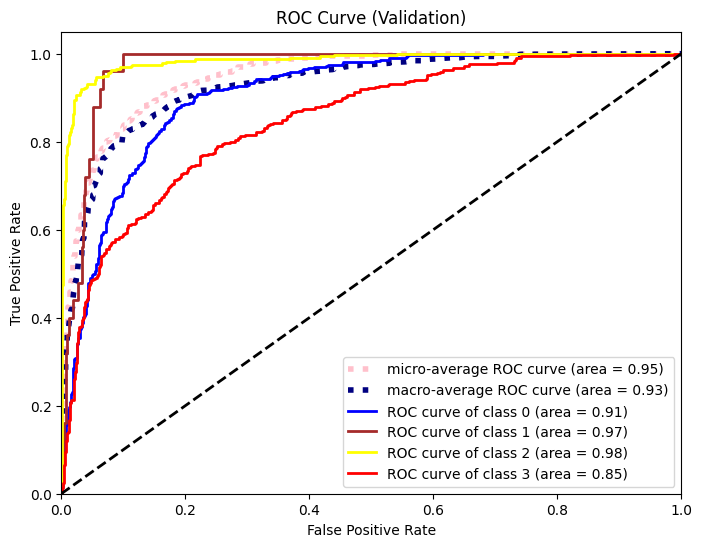

In [29]:
plot_ROC_AUC(X_test,y_test, 'reduced_model_ROC_test.png')

40/40 [==============================] - 1s 24ms/step
Validation set accuracy: 0.7896794370602033
Validation set precision: 0.8475666285935908
Validation set recall / sensitivity: 0.6052604635660594
Validation set specificity: ?
Validation set F1 score: 0.6128792438211452


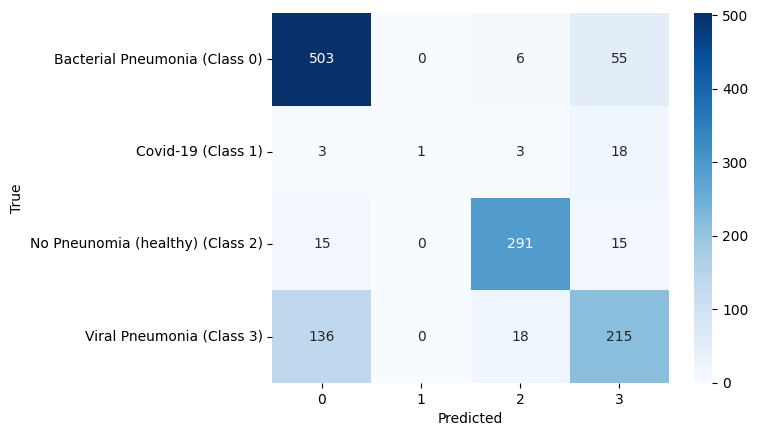

In [30]:
plot_cm(X_test,y_test, 'reduced_model_testset_confusion_matrix.png')

In [31]:
class_report(X_test,y_test)


Classification Report

40/40 [==============================] - 1s 26ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.77      0.89      0.82       564
              Covid-19 (Class 1)       1.00      0.04      0.08        25
No Pneunomia (healthy) (Class 2)       0.92      0.91      0.91       321
       Viral Pneumonia (Class 3)       0.71      0.58      0.64       369

                        accuracy                           0.79      1279
                       macro avg       0.85      0.61      0.61      1279
                    weighted avg       0.79      0.79      0.78      1279



## using class weights

In [97]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, AveragePooling2D
from tensorflow.keras import regularizers

from tensorflow.keras import layers, models
tf.keras.utils.set_random_seed(43)

# Define the CNN model
model = models.Sequential()

# Add the 1st convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization(axis=1))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 2nd convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 3rd convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 4th convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 5th convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 6th convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output of the last convolutional layer
model.add(layers.Flatten())

# Add the 1st dense layer
model.add(layers.Dense(32, activation='relu'))

# Add the 2nd dense layer
model.add(layers.Dense(32, activation='relu'))

# Add the output layer
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
#we can change the loss function
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0001)
model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 156, 156, 32)      320       
                                                                 
 batch_normalization_8 (Batc  (None, 156, 156, 32)     624       
 hNormalization)                                                 
                                                                 
 max_pooling2d_52 (MaxPoolin  (None, 78, 78, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 39, 39, 32)       0         
 g2D)                                                            
                                                     

In [98]:
from sklearn.utils import compute_class_weight

class_weights = dict(enumerate(compute_class_weight(class_weight = 'balanced', classes = np.unique(np.argmax(y_train, axis=1)), y = np.argmax(y_train, axis=1))))

hist = model.fit(X_train, y_train, epochs=8, batch_size=32, validation_data=(X_val, y_val), class_weight=class_weights)

Epoch 1/8


2023-03-05 11:12:48.841725: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - ETA: 0s - loss: 1.1281 - accuracy: 0.4356

2023-03-05 11:12:59.570097: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


120/120 [==============================] - 12s 96ms/step - loss: 1.1281 - accuracy: 0.4356 - val_loss: 1.1976 - val_accuracy: 0.4566
Epoch 2/8
120/120 [==============================] - 11s 90ms/step - loss: 0.8058 - accuracy: 0.5978 - val_loss: 1.1516 - val_accuracy: 0.5106
Epoch 3/8
120/120 [==============================] - 11s 89ms/step - loss: 0.6718 - accuracy: 0.6651 - val_loss: 0.8891 - val_accuracy: 0.6396
Epoch 4/8
120/120 [==============================] - 10s 87ms/step - loss: 0.6422 - accuracy: 0.6810 - val_loss: 0.7188 - val_accuracy: 0.6904
Epoch 5/8
120/120 [==============================] - 10s 87ms/step - loss: 0.6121 - accuracy: 0.6985 - val_loss: 0.6485 - val_accuracy: 0.7123
Epoch 6/8
120/120 [==============================] - 10s 87ms/step - loss: 0.5961 - accuracy: 0.7029 - val_loss: 0.6240 - val_accuracy: 0.7271
Epoch 7/8
120/120 [==============================] - 10s 86ms/step - loss: 0.5595 - accuracy: 0.7207 - val_loss: 0.6772 - val_accuracy: 0.7287
Epoch 8/8

### validation

 1/40 [..............................] - ETA: 7s

2023-03-05 10:31:45.175424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 26ms/step


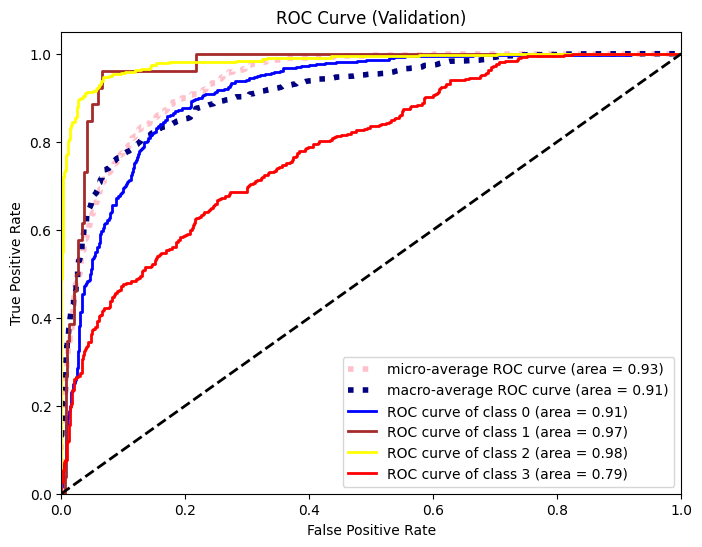

In [53]:
plot_ROC_AUC(X_val,y_val, 'tuned_weighted_model_ROC_validation.png')

40/40 [==============================] - 1s 25ms/step
Validation set accuracy: 0.7521501172791243
Validation set precision: 0.6502395726884627
Validation set recall / sensitivity: 0.786119333331527
Validation set specificity: ?
Validation set F1 score: 0.6671436161001929


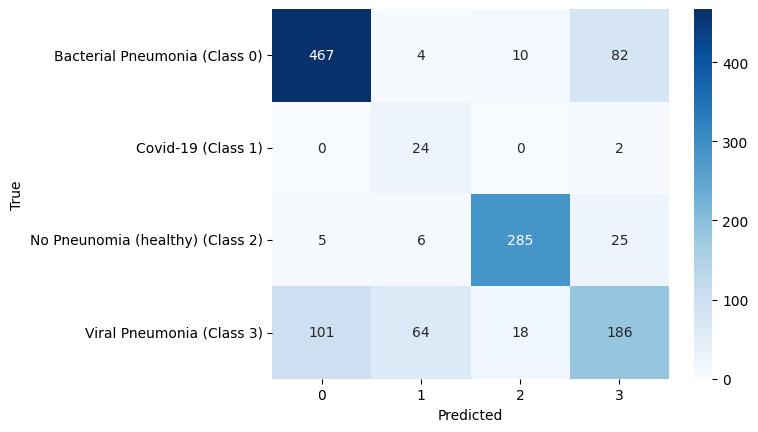

In [54]:
plot_cm(X_val,y_val,'tuned_weighted_validationset_confusion_matrix.png')

In [55]:
class_report(X_val,y_val)


Classification Report

40/40 [==============================] - 1s 26ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.82      0.83      0.82       563
              Covid-19 (Class 1)       0.24      0.92      0.39        26
No Pneunomia (healthy) (Class 2)       0.91      0.89      0.90       321
       Viral Pneumonia (Class 3)       0.63      0.50      0.56       369

                        accuracy                           0.75      1279
                       macro avg       0.65      0.79      0.67      1279
                    weighted avg       0.77      0.75      0.76      1279



### test

40/40 [==============================] - 1s 26ms/step


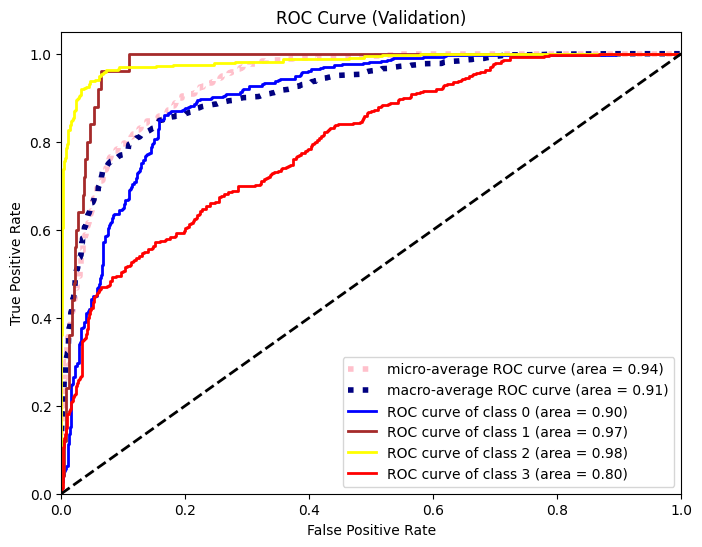

In [56]:
plot_ROC_AUC(X_test,y_test, 'tuned_weighted_model_ROC_test.png')

40/40 [==============================] - 1s 26ms/step
Validation set accuracy: 0.7615324472243941
Validation set precision: 0.6567571649655046
Validation set recall / sensitivity: 0.7861833452695235
Validation set specificity: ?
Validation set F1 score: 0.6738537368312442


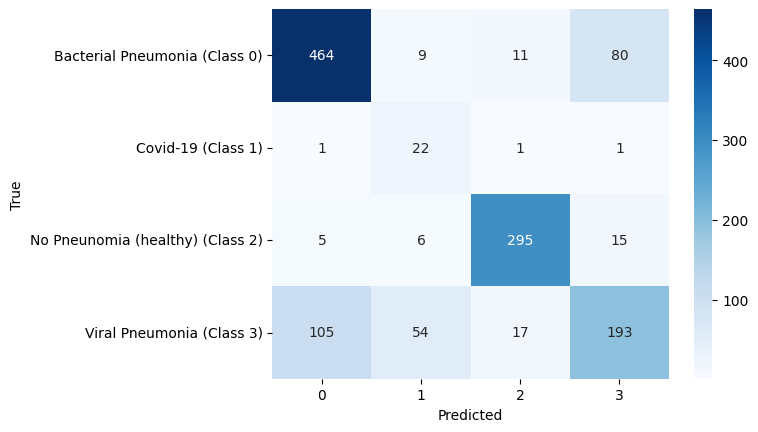

In [57]:
plot_cm(X_test,y_test, 'tuned_weighted_model_testset_confusion_matrix.png')

In [40]:
class_report(X_test,y_test)


Classification Report

40/40 [==============================] - 1s 25ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.81      0.82      0.81       564
              Covid-19 (Class 1)       0.24      0.88      0.38        25
No Pneunomia (healthy) (Class 2)       0.91      0.92      0.91       321
       Viral Pneumonia (Class 3)       0.67      0.52      0.59       369

                        accuracy                           0.76      1279
                       macro avg       0.66      0.79      0.67      1279
                    weighted avg       0.78      0.76      0.77      1279



## using data augmentation + class weights

In [58]:
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, AveragePooling2D
from tensorflow.keras import regularizers

from tensorflow.keras import layers, models
tf.keras.utils.set_random_seed(43)

# Define the CNN model
model = models.Sequential()

# Add the 1st convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=X_train.shape[1:]))
model.add(BatchNormalization(axis=1))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 2nd convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 3rd convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 4th convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 5th convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Add the 6th convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', padding = 'same'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output of the last convolutional layer
model.add(layers.Flatten())

# Add the 1st dense layer
model.add(layers.Dense(32, activation='relu'))

# Add the 2nd dense layer
model.add(layers.Dense(32, activation='relu'))

# Add the output layer
model.add(layers.Dense(4, activation='softmax'))

# Compile the model
#we can change the loss function
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0001)
model.compile(loss='CategoricalCrossentropy', optimizer=opt, metrics=['accuracy'])

# Print a summary of the model architecture
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 156, 156, 32)      320       
                                                                 
 batch_normalization_6 (Batc  (None, 156, 156, 32)     624       
 hNormalization)                                                 
                                                                 
 max_pooling2d_40 (MaxPoolin  (None, 78, 78, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_45 (Conv2D)          (None, 78, 78, 32)        9248      
                                                                 
 max_pooling2d_41 (MaxPoolin  (None, 39, 39, 32)       0         
 g2D)                                                            
                                                      

In [59]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight
tf.keras.utils.set_random_seed(43)

# ImageDataGenerator
# Augmentation
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,  
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=[0.8,1.2],
                             fill_mode='nearest',
                             data_format="channels_last")

# Check class distribtution

#manual
#class_weights = dict(enumerate(1-(pd.DataFrame(labels).value_counts(normalize=True)).sort_index()))

#sklearn
class_weights = dict(enumerate(compute_class_weight(class_weight = 'balanced', classes = np.unique(np.argmax(y_train, axis=1)), y = np.argmax(y_train, axis=1))))

epochs = 41
batch_size = 32


train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed=43)

history = model.fit(train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight = class_weights)


Epoch 1/41


2023-03-05 10:33:31.755363: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - ETA: 0s - loss: 1.3314 - accuracy: 0.2583

2023-03-05 10:33:42.850248: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 13s 102ms/step - loss: 1.3314 - accuracy: 0.2583 - val_loss: 1.4336 - val_accuracy: 0.0203
Epoch 2/41
119/119 [==============================] - 11s 95ms/step - loss: 1.2220 - accuracy: 0.2985 - val_loss: 1.2764 - val_accuracy: 0.3964
Epoch 3/41
119/119 [==============================] - 11s 90ms/step - loss: 1.1171 - accuracy: 0.3440 - val_loss: 1.0880 - val_accuracy: 0.5207
Epoch 4/41
119/119 [==============================] - 11s 91ms/step - loss: 1.1786 - accuracy: 0.3806 - val_loss: 1.0624 - val_accuracy: 0.6083
Epoch 5/41
119/119 [==============================] - 10s 88ms/step - loss: 1.0023 - accuracy: 0.4905 - val_loss: 0.9468 - val_accuracy: 0.6138
Epoch 6/41
119/119 [==============================] - 11s 92ms/step - loss: 0.9066 - accuracy: 0.5639 - val_loss: 0.8241 - val_accuracy: 0.6482
Epoch 7/41
119/119 [==============================] - 11s 91ms/step - loss: 0.9207 - accuracy: 0.5726 - val_loss: 0.7993 - val_accuracy: 0.6755
Ep

### validation

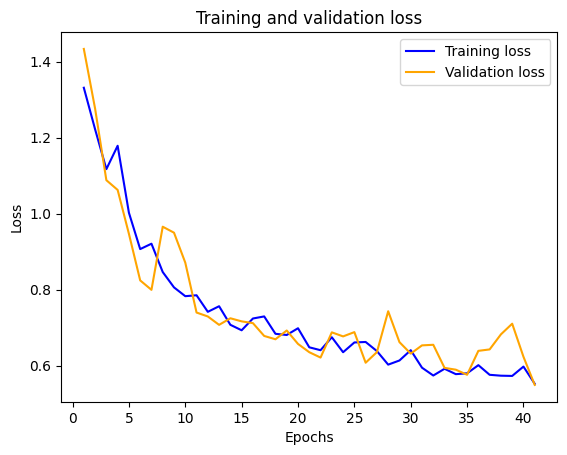

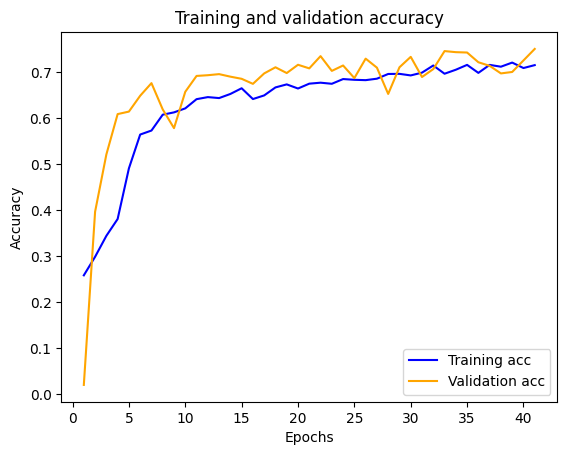

In [60]:
plot_loss_acc(history, 'tuned_weighted_augmented_model_loss', 'tuned_weighted_augmented_accuracy.png')

 3/40 [=>............................] - ETA: 0s

2023-03-05 10:41:48.517590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 1s 26ms/step


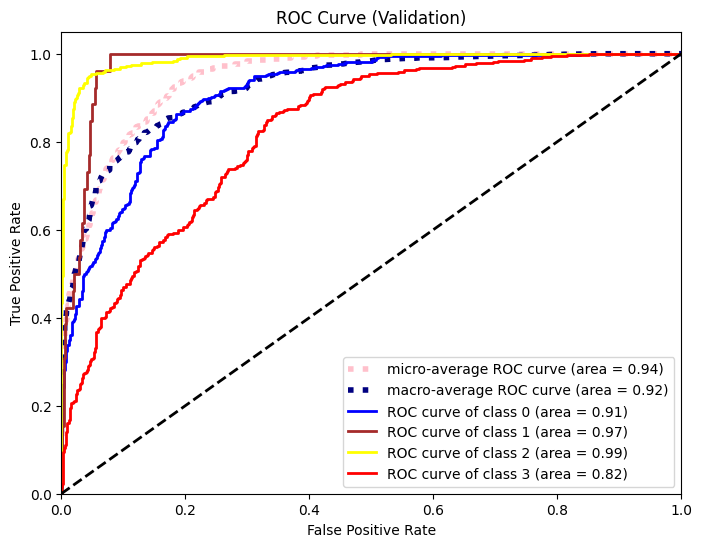

In [61]:
plot_ROC_AUC(X_val,y_val, 'tuned_weighted_augmented_model_ROC_validation.png')

40/40 [==============================] - 1s 24ms/step
Validation set accuracy: 0.7498045347928068
Validation set precision: 0.6473308707665522
Validation set recall / sensitivity: 0.774364844308548
Validation set specificity: ?
Validation set F1 score: 0.6614392218938894


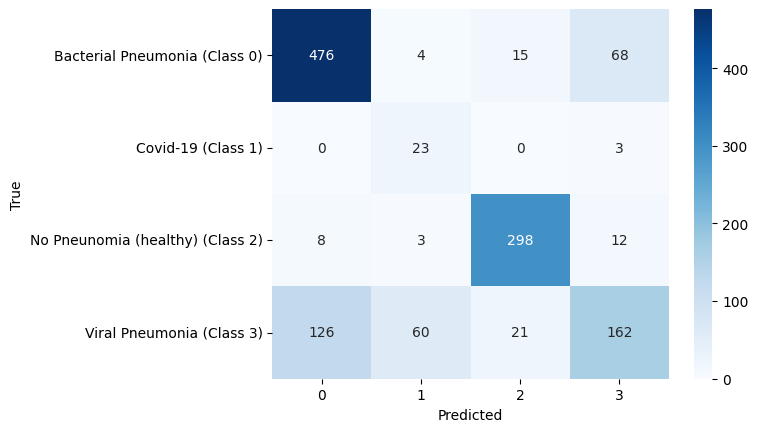

In [62]:
plot_cm(X_val,y_val,'tuned_weighted_augmented_validationset_confusion_matrix.png')

In [63]:
class_report(X_val,y_val)


Classification Report

40/40 [==============================] - 1s 25ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.78      0.85      0.81       563
              Covid-19 (Class 1)       0.26      0.88      0.40        26
No Pneunomia (healthy) (Class 2)       0.89      0.93      0.91       321
       Viral Pneumonia (Class 3)       0.66      0.44      0.53       369

                        accuracy                           0.75      1279
                       macro avg       0.65      0.77      0.66      1279
                    weighted avg       0.76      0.75      0.75      1279



### test

40/40 [==============================] - 1s 26ms/step


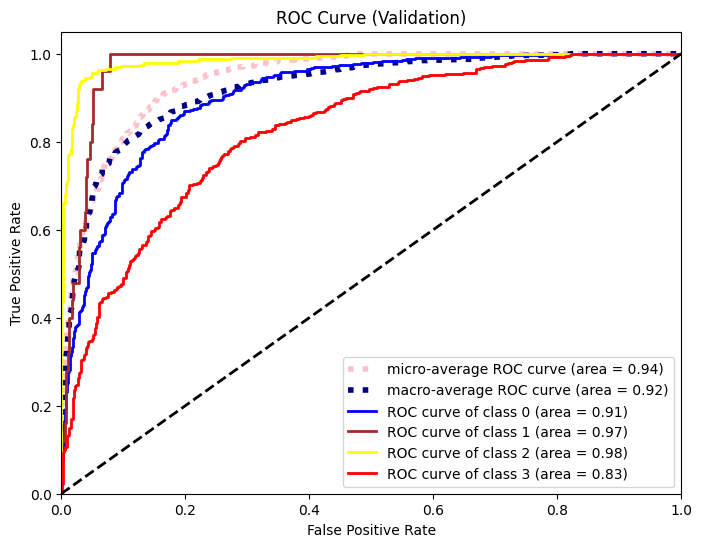

In [64]:
plot_ROC_AUC(X_test,y_test, 'tuned_weighted_augmented_model_ROC_test.png')

40/40 [==============================] - 1s 25ms/step
Validation set accuracy: 0.7615324472243941
Validation set precision: 0.6549773561122554
Validation set recall / sensitivity: 0.7642653706065794
Validation set specificity: ?
Validation set F1 score: 0.6677795838442527


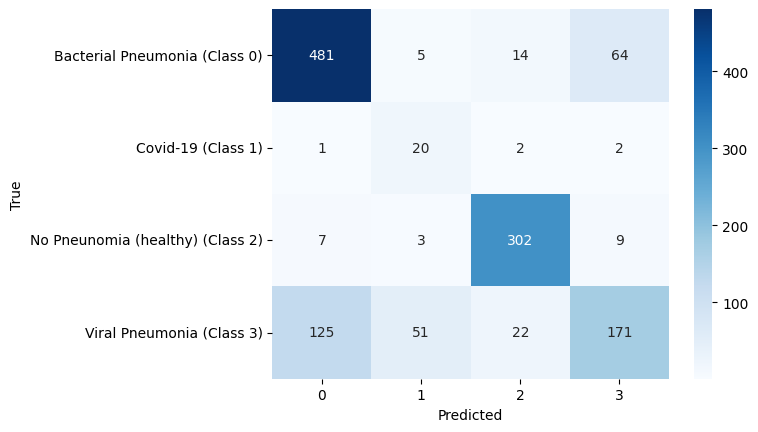

In [65]:
plot_cm(X_test,y_test, 'tuned_weighted_augmented_model_testset_confusion_matrix.png')

In [66]:
class_report(X_test,y_test)


Classification Report

40/40 [==============================] - 1s 25ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.78      0.85      0.82       564
              Covid-19 (Class 1)       0.25      0.80      0.38        25
No Pneunomia (healthy) (Class 2)       0.89      0.94      0.91       321
       Viral Pneumonia (Class 3)       0.70      0.46      0.56       369

                        accuracy                           0.76      1279
                       macro avg       0.65      0.76      0.67      1279
                    weighted avg       0.77      0.76      0.76      1279



# Transfer Learning

VGG16

In [78]:
from keras.applications.vgg16 import VGG16
# load model without output layer and specify a new input shape for images
### PUT YOUR CODE HERE ###
vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(156, 156, 3))
### END ###

In [79]:
# mark loaded layers as not trainable
for layer in vgg_model.layers:
	layer.trainable = False

In [80]:
from tensorflow.keras import layers
from keras.models import Model
tf.keras.utils.set_random_seed(43)

# add new classifier layers
#add flatten layer
flat1 = layers.Flatten()(vgg_model.layers[-1].output)
#add Dense layer
class1 = layers.Dense(128, activation='relu')(flat1)
#add output layer with softmax activation
output = layers.Dense(4, activation='softmax')(class1)
# define new model
model = Model(inputs=vgg_model.inputs, outputs=output)
# summarize
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 156, 156, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 156, 156, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 156, 156, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 78, 78, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 78, 78, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 78, 78, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 39, 39, 128)       0   

In [81]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator
# Augmentation
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,  
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=[0.8,1.2],
                             fill_mode='nearest',
                             data_format="channels_last")

epochs = 18
batch_size = 32


train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed=43)

## !!Before fitting the model add all three channels back to the data in pre-processing!!

In [82]:
# compile model
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.001, decay=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
tf.keras.utils.set_random_seed(43)

from sklearn.utils import compute_class_weight

class_weights = dict(enumerate(compute_class_weight(class_weight = 'balanced', classes = np.unique(np.argmax(y_train, axis=1)), y = np.argmax(y_train, axis=1))))

# fit model
history = model.fit(train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weights)

Epoch 1/18


2023-03-05 10:44:15.828314: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - ETA: 0s - loss: 0.9682 - accuracy: 0.5715

2023-03-05 10:44:48.737944: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


119/119 [==============================] - 44s 363ms/step - loss: 0.9682 - accuracy: 0.5715 - val_loss: 0.7388 - val_accuracy: 0.7177
Epoch 2/18
119/119 [==============================] - 43s 358ms/step - loss: 0.7121 - accuracy: 0.6720 - val_loss: 0.7750 - val_accuracy: 0.6935
Epoch 3/18
119/119 [==============================] - 43s 357ms/step - loss: 0.7227 - accuracy: 0.6728 - val_loss: 0.6698 - val_accuracy: 0.7224
Epoch 4/18
119/119 [==============================] - 42s 356ms/step - loss: 0.6377 - accuracy: 0.7083 - val_loss: 0.6265 - val_accuracy: 0.7365
Epoch 5/18
119/119 [==============================] - 42s 352ms/step - loss: 0.6346 - accuracy: 0.7070 - val_loss: 0.7831 - val_accuracy: 0.7107
Epoch 6/18
119/119 [==============================] - 42s 352ms/step - loss: 0.6192 - accuracy: 0.7112 - val_loss: 0.7074 - val_accuracy: 0.7146
Epoch 7/18
119/119 [==============================] - 42s 357ms/step - loss: 0.5928 - accuracy: 0.7246 - val_loss: 0.7786 - val_accuracy: 0.6

### validation

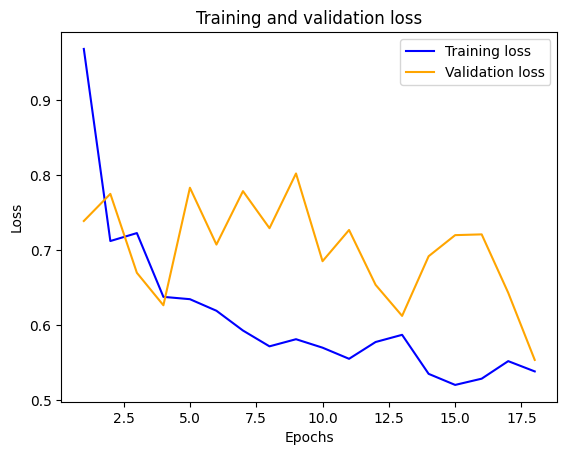

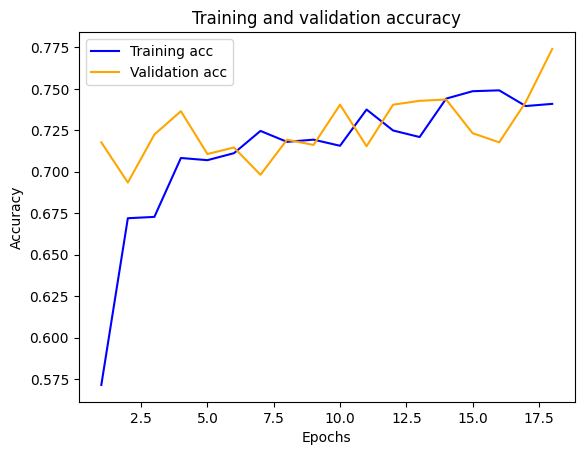

In [83]:
plot_loss_acc(history, 'tuned_weighted_augmented_transfered_model_loss', 'tuned_weighted_augmented_transfered_accuracy.png')

2023-03-05 10:57:18.249162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


40/40 [==============================] - 11s 268ms/step


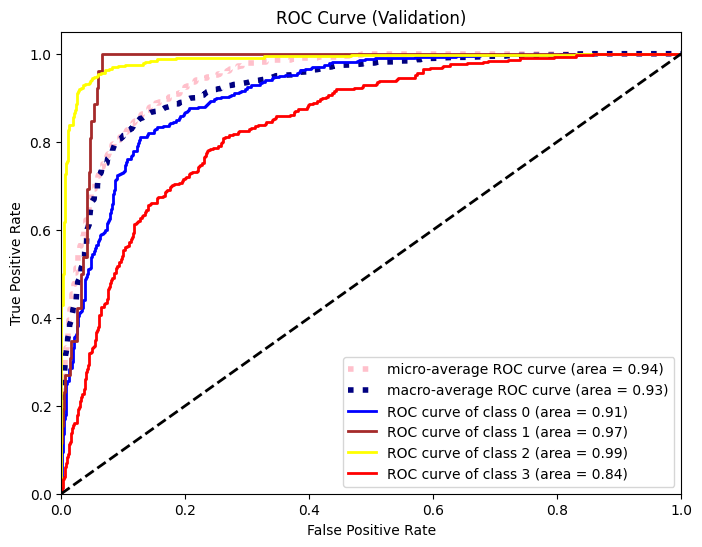

In [84]:
plot_ROC_AUC(X_val,y_val, 'tuned_weighted_augmented_transfered_model_ROC_val.png')

40/40 [==============================] - 10s 266ms/step
Validation set accuracy: 0.7740422204847537
Validation set precision: 0.6452712776474023
Validation set recall / sensitivity: 0.6832231781940897
Validation set specificity: ?
Validation set F1 score: 0.657407719143851


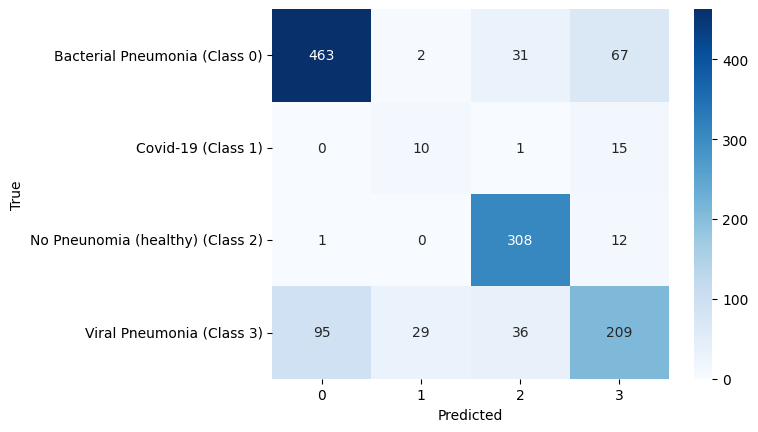

In [85]:
plot_cm(X_val,y_val,'tuned_weighted_augmented_transfered_validationset_confusion_matrix.png')

In [86]:
class_report(X_val,y_val)


Classification Report

40/40 [==============================] - 10s 267ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.83      0.82      0.83       563
              Covid-19 (Class 1)       0.24      0.38      0.30        26
No Pneunomia (healthy) (Class 2)       0.82      0.96      0.88       321
       Viral Pneumonia (Class 3)       0.69      0.57      0.62       369

                        accuracy                           0.77      1279
                       macro avg       0.65      0.68      0.66      1279
                    weighted avg       0.77      0.77      0.77      1279



### test

40/40 [==============================] - 10s 264ms/step


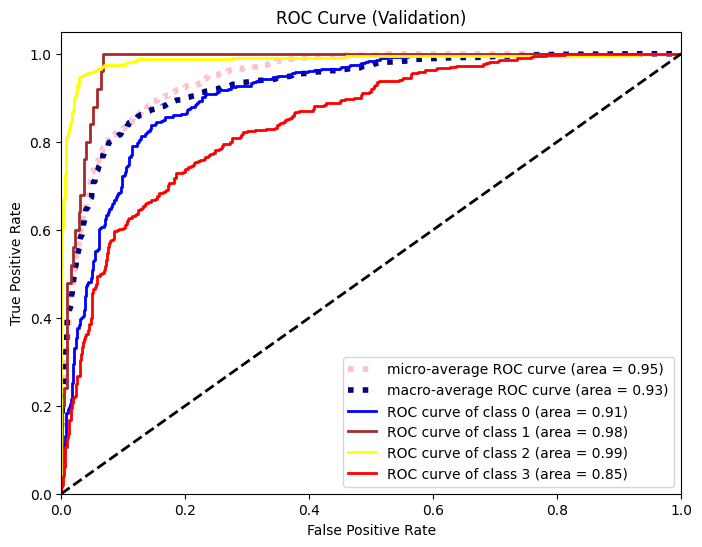

In [87]:
plot_ROC_AUC(X_test,y_test, 'tuned_weighted_augmented_transfered_model_ROC_test.png')

40/40 [==============================] - 10s 266ms/step
Validation set accuracy: 0.7896794370602033
Validation set precision: 0.6948788372847279
Validation set recall / sensitivity: 0.7471397062350023
Validation set specificity: ?
Validation set F1 score: 0.7130700455831134


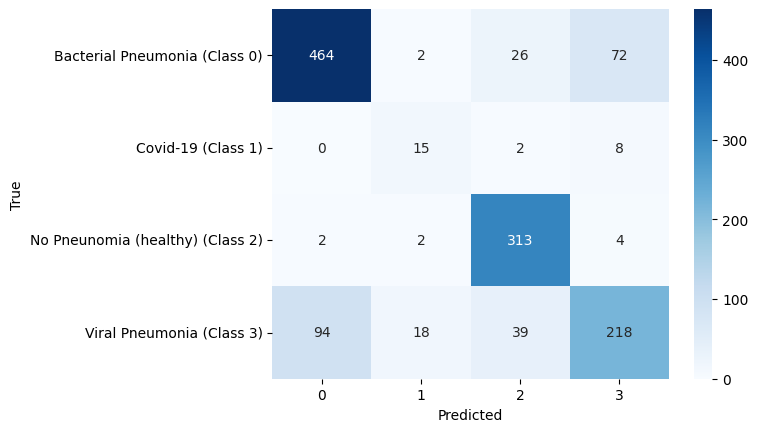

In [88]:
plot_cm(X_test,y_test,'tuned_weighted_augmented_transfered_testset_confusion_matrix.png')

In [89]:
class_report(X_test,y_test)


Classification Report

40/40 [==============================] - 11s 270ms/step
                                  precision    recall  f1-score   support

   Bacterial Pneumonia (Class 0)       0.83      0.82      0.83       564
              Covid-19 (Class 1)       0.41      0.60      0.48        25
No Pneunomia (healthy) (Class 2)       0.82      0.98      0.89       321
       Viral Pneumonia (Class 3)       0.72      0.59      0.65       369

                        accuracy                           0.79      1279
                       macro avg       0.69      0.75      0.71      1279
                    weighted avg       0.79      0.79      0.79      1279



ResNet50

In [ ]:
from keras.applications import ResNet50
# load model without output layer and specify a new input shape for images
### PUT YOUR CODE HERE ###
ResNet50_model = ResNet50(include_top=False, weights='imagenet', input_shape=(156, 156, 3))
### END ###

In [ ]:
for layer in ResNet50_model.layers:
	layer.trainable = False

In [ ]:
from tensorflow.keras import layers
from keras.models import Model
tf.keras.utils.set_random_seed(43)

# add new classifier layers
#add flatten layer
flat1 = layers.Flatten()(ResNet50_model.layers[-1].output)
#add Dense layer
class1 = layers.Dense(128, activation='relu')(flat1)
class2 = layers.Dense(64, activation='relu')(class1)
#add output layer with softmax activation
output = layers.Dense(4, activation='softmax')(class2)
# define new model
model = Model(inputs=ResNet50_model.inputs, outputs=output)
# summarize
model.summary()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# ImageDataGenerator
# Augmentation
datagen = ImageDataGenerator(rotation_range=20,
                             width_shift_range=0.2,  
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=[0.8,1.2],
                             fill_mode='nearest',
                             data_format="channels_last")

epochs = 20
batch_size = 32


train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed=43)

In [ ]:
# compile model
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001, decay=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

from sklearn.utils import compute_class_weight

class_weights = dict(enumerate(compute_class_weight(class_weight = 'balanced', classes = np.unique(np.argmax(y_train, axis=1)), y = np.argmax(y_train, axis=1))))

# fit model
history = model.fit(train_generator,
    steps_per_epoch=len(X_train) // batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    class_weight=class_weights)